This script accesses the MIMIC database and extracts sub-tables for use in defining the final septic patient cohort in the [next step](https://colab.research.google.com/drive/1txkCiCsdXZ4wKlkV2yjePUq_nbuXjcVN?usp=chrome_ntp#scrollTo=LXoZFtcTGLYb&uniqifier=1).

sub-tables:
* trum_demog: Trauma Demographics (with truma population ids `trum_ids_df`)
* cx: Culture
* abx (Antibiotics administration)
* SOFA score for Trauma patient


**Resference**:

* This is a pure-python implementation based on a corrected version of the original R repo accompanying ["Defining Posttraumatic Sepsis for Population-Level Research"](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2800552) for MIMIC Dataset

* It is also sourced and modified from: [Microsoft mimic_sepsis](https://github.com/microsoft/mimic_sepsis/tree/main)


**Notes**:

This notebook assumes you have access to MIMIC III (v1.4) on Google BigQuery.
> - To get access for MIMIC III(v1.4) follow [link](https://physionet.org/content/mimiciii/1.4/)
> - To set up MIMIC data on Google BigQuery, follow [link](https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/)
> - To access MIMIC data in Google Colab, check the [link](https://colab.research.google.com/drive/1REu-ofzNzqsTT1cxLHIegPB0nGmwKaM0?usp=sharing#scrollTo=s-MoFA6NkkbZ)

# Set up

In [ ]:
# import gzip
import os
# import re
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# cd to code folder
%cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project
import mimic_utils as utils
import mimiciii_icu_trauma_patient_cohort as trauma_cohort

# Project Path
PROJECT_PATH = '/content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project'
# Data Path
# mimic original dataset path
DATASET_PATH = os.path.join(PROJECT_PATH, '1.4') # Dataset to local path
PREPROCESS_DATA_PATH = os.path.join(PROJECT_PATH, 'preprocess')
SEPSIS_PREPROCESS_DATA_PATH = os.path.join(PROJECT_PATH, 'preprocess', 'sepsis_preprocess')

# environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3'  #this need to change according to your project_id in BigQuery

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project


## halper fun

In [ ]:
# def assign_icustay_id(row, icustay_df, time_column='charttime'):
#   """
#   this function fill missing icustay_id(NA/NaN values) according to ICUSTAYS.csv.gz table
#     icu_stay: load from ICUSTAYS.csv.gz
#     df: the row Series that needed to fillin icustay_id (the columns in this table should be all lowercase)
#     time_column: the time column that used to identify
#   """
#   row[time_column] = pd.to_datetime(row[time_column])
#   # generate missing icustay_id
#   if ('icustay_id' not in row.index) or (pd.isna(row.icustay_id)):
#     # extract all icustay for a given subject_id
#     icustay = icustay_df[icustay_df.SUBJECT_ID == row.subject_id]
#     # check if with in duration
#     target_id = icustay.loc[(icustay['INTIME'] <= row[time_column]) & (row[time_column] <= icustay['OUTTIME'])].ICUSTAY_ID
#     # print(target_id)
#     if target_id.shape[0] == 1: # if in one duration
#       return target_id.values[0]
#     elif target_id.shape[0] > 1:
#       print("ERROR1: one charttime matching with multi icu duration", row)
#       return 'ERROR1'

#     # if not in aby duration, then check if in same day as intime date
#     # ""--  we allow 24 hours before ICU admission (to grab labs before admit)"" from MIT-LCP icustay_hours.sql
#     target_id = icustay[icustay['INTIME'].dt.date == row[time_column].date()].ICUSTAY_ID
#     if target_id.shape[0] == 1: # if at one stare date
#       return target_id.values[0]
#     elif target_id.shape[0] > 1:
#       print("ERROR2: one charttime matching with multi icu intime date", row)
#       return 'ERROR2'
#     return np.nan # not match
#   else: # if not missing, use the original icustay_id
#     return row.icustay_id

# PreProcess

## Trauma Demographics

* trum_ids_df: hadm_id for Trauma Population
* trum_demog:
> culumns:
> * IDs: 'hadm_id',
> * Tims/duration: 'adm_date', 'admittime', 'dischtime', 'los_hospital_hours',
> * Outhers: 'hospital_expire_flag'

In [ ]:
import mimiciii_icu_trauma_patient_cohort as TraumaCohort # for trauma cohort

# Select Trauma Population (IDs)
TRUM_df = trauma_cohort.trum_population_ids(
    DATASET_PATH, PREPROCESS_DATA_PATH, #local path: mimiciii dataset
    PROJECT_ID,                         #mimiciii dataset: bigquery id
    vent_type=['MechVent'], vent_threshold=2,
    is_report=True)
#This table should contain 1 row per patient (with unique hadm_id)
trum_ids_df = TRUM_df[['hadm_id']].drop_duplicates() # we only need Hosipital Admission ID

,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,2209
hadm_id,57328,4977,2242
icustay_id,61051,5410,2545


In [ ]:
#####################################################################

#Trauma Demographics
# This table(demog_df) should contain 1 row per patient with unique hadm_id
# and corresponding info: admittime, dischtime, hospital length of stay, died flag

#####################################################################
# print(trum_ids_df.shape)
# load demographics
demog_path = os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_demographics.csv")
if os.path.exists(demog_path):
    trum_demog = pd.read_csv(demog_path, index_col=0)
else:
    demog_df = utils.demog_sql2df(PROJECT_ID, saved_path=PREPROCESS_DATA_PATH)
    # Extract on truma pacient info
    trum_demog = trum_ids_df.merge(demog_df[
        ['hadm_id', 'admittime',	'dischtime', 'los_hospital_hours', 'hospital_expire_flag']],
                                   on='hadm_id', how='left').drop_duplicates(['hadm_id'])
    trum_demog.to_csv(demog_path)

trum_demog['adm_date'] = pd.to_datetime(trum_demog.admittime).dt.date
trum_demog.head()

,hadm_id,admittime,dischtime,los_hospital_hours,hospital_expire_flag,adm_date
0,146828,2186-10-01 23:15:00,2186-10-11 18:00:00,235,0,2186-10-01
1,123010,2111-08-29 03:03:00,2111-09-03 14:24:00,131,0,2111-08-29
2,168006,2140-11-06 11:07:00,2140-11-09 20:36:00,81,1,2140-11-06
3,137432,2197-07-14 20:18:00,2197-08-01 13:15:00,425,0,2197-07-14
4,103631,2158-06-24 18:50:00,2158-07-21 14:10:00,644,0,2158-06-24


## Culture

In [ ]:
def positive_culture_selection_me(project_id, trum_ids_df, is_report=False):
  """
    Slect culture recordes with positive result
    Data are extract from
      MicrobiologyEvents from local path(Google drive): missing icustay_ids
    duplicates: (NOT Droped)
      may have multiples clture happening at same time
      with in each sources AND
      overlap between two sources file
  """
  # Extra qualify culture from MicrobiologyEvents file for trauma patients
  culture_me_df = utils.run_query("""
        SELECT subject_id, hadm_id, charttime
        , spec_itemid, spec_type_desc, org_name, isolate_num
        FROM `physionet-data.mimiciii_clinical.microbiologyevents`
        where spec_itemid in (
          70077, 70079, 70081	  --URINE
          ,70012	--BLOOD CULTURE
          ,70087	--Blood (CMV AB)
          ,70011	--BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)
          ,70013	--FLUID RECEIVED IN BLOOD CULTURE BOTTLES
          ,70051	--FLUID,OTHER
          ,70062	--SPUTUM
          ,70026	--CSF;SPINAL FLUID
          ,70021	--BRONCHOALVEOLAR LAVAGE
          ,70023	--CATHETER TIP-IV
          ,70053	--PERITONEAL FLUID
          ,70003	--ABSCESS
          ,70054	--PLEURAL FLUID
          ,70076	--TISSUE
          ,70022	--BRONCHIAL WASHINGS
          ,70020	--BRONCHIAL BRUSH
          ,70005	--ASPIRATE
          ,70072	--TRACHEAL ASPIRATE
          ,70036	--FLUID WOUND
          ,70047	--JOINT FLUID
          ,70010	--BIOPSY
          ,70090	--Mini-BAL
          ,70009	--BILE
        )
        AND hadm_id IS NOT NULL
        AND charttime IS NOT NULL
        ORDER BY hadm_id, charttime, spec_itemid;
        """, project_id)

  # select trum pacients
  trum_culture_df = culture_me_df[culture_me_df.hadm_id.isin(trum_ids_df.hadm_id)]

  if is_report:
    print(f"num unique culture type from microbiologyevents: {trum_culture_df.spec_type_desc.nunique()}(name), {trum_culture_df.spec_itemid.nunique()}(ids)")
    print("Notice: may have multiples clture happening at same time")
    print(f"\nTOTAL %d culture samples for %d patients in Trauma Cohort"%(trum_culture_df.shape[0], trum_culture_df.hadm_id.nunique()))
  return trum_culture_df.sort_values(['subject_id', 'hadm_id', 'charttime']).reset_index(drop=True)

cx_me = positive_culture_selection_me(PROJECT_ID, trum_ids_df, is_report=True)

num unique culture type from microbiologyevents: 23(name), 25(ids)
Notice: may have multiples clture happening at same time

TOTAL 41426 culture samples for 1829 pacitients in Truama Cohort:


In [ ]:
positive_cx_me = cx_me[cx_me.org_name.notna()]
print(f"%d culture samples (with Positive Results) for %d patients in Trauma Cohort"%(positive_cx_me.shape[0], positive_cx_me.hadm_id.nunique()))


24604 culture samples (with Positive Result) for 1288 patient in Truama Cohort


In [ ]:
na_count_tabel = cx_me.isna().sum().to_frame(name='num')
na_count_tabel['rate'] = na_count_tabel.num / cx_me.shape[0]
na_count_tabel

,num,rate
subject_id,0,0.000000
hadm_id,0,0.000000
charttime,0,0.000000
spec_itemid,0,0.000000
spec_type_desc,0,0.000000
org_name,16822,0.406073
isolate_num,16822,0.406073


In [ ]:
def culture_selection(project_id,
                      trum_ids_df, is_report=False
                      , drop_nan_icustay=False,  dataset_path=None):
  """
    Data are extract from 2 Table:
      ChartEvents by using Bigquene
      MicrobiologyEvents by using Bigquene: missing icustay_ids
    duplicates: (NOT Droped)
      may have multiples clture happening at same time
      with in each sources AND
      overlap between two sources file
    drop_nan_icustay=True:
      means only keep the event that happend during the icu stay
      (Currently) by default set to False,
      cause there is no much different and filling icustay takes a long time.
      if set to True, then also need to set dataset_path (dataset path in local drive)
  """
  # Extra qualify culture from ChartEvents file for trauma patients
  qualify_culture_ce_query = """
      SELECT ce.subject_id, ce.hadm_id, ce.icustay_id, ce.charttime
      , ce.itemid, d_items.label
      FROM `physionet-data.mimiciii_clinical.chartevents` ce
      INNER JOIN `physionet-data.mimiciii_clinical.d_items` d_items
          ON ce.itemid = d_items.itemid
      WHERE ce.itemid in (
        942  --blood cultures
        , 225722 --Arterial Line Tip Cultured
        , 225723 --CCO PAC Line Tip Cultured
        , 225724 --Cordis/Introducer Line Tip Cultured
        , 225725 --Dialysis Catheter Tip Cultured
        , 225726 --Tunneled (Hickman) Line Tip Cultured
        , 225728 --Midline Tip Cultured
        , 225729 --Multi Lumen Line Tip Cultured
        , 225730 --PA Catheter Line Tip Cultured
        , 225731 --Pheresis Catheter Line Tip Cultured
        , 225734 --Presep Catheter Line Tip Cultured
        , 225735 --Trauma Line Tip Cultured
        , 226131 --ICP Line Tip Cultured
        , 227726 --AVA Line Tip Cultured
        --Following culture items(in chartevents) are selected,
        --but not show in trauma patients cohort
        , 6035, 6043, 70006,70024, 70037, 70041, 70055, 70057, 70063, 70075, 70083, 80220
        , 225444, 225727, 225732, 225733, 225736, 225768, 225814, 225816, 225817, 225818
        , 938, 942, 3333, 70011, 70012, 70013, 70014, 70016, 70060, 225401  --blood cultures
        , 941, 4855, 225454 -- urine culture
        , 225437            --CSF Culture
        , 2929, 225451      --sputum culture
        )
      --ORDER BY subject_id, hadm_id, icustay_id, charttime
  """
  culture_ce_df = utils.run_query(qualify_culture_ce_query, project_id)
  culture_ce_df.rename({'itemid':'spec_itemid',
                        'label':'spec_type_desc'}, axis=1, inplace=True)
  culture_ce_df['linksto'] = 'ChartEvents'   # mark the source file

  # Extra qualify culture from MicrobiologyEvents file for trauma patients
  culture_me_df = utils.run_query("""
        SELECT subject_id, hadm_id, charttime
        , spec_itemid, spec_type_desc, org_name, isolate_num
        FROM `physionet-data.mimiciii_clinical.microbiologyevents`
        where spec_itemid in (
          70077, 70079, 70081	  --URINE
          ,70012	--BLOOD CULTURE
          ,70087	--Blood (CMV AB)
          ,70011	--BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)
          ,70013	--FLUID RECEIVED IN BLOOD CULTURE BOTTLES
          ,70051	--FLUID,OTHER
          ,70062	--SPUTUM
          ,70026	--CSF;SPINAL FLUID
          ,70021	--BRONCHOALVEOLAR LAVAGE
          ,70023	--CATHETER TIP-IV
          ,70053	--PERITONEAL FLUID
          ,70003	--ABSCESS
          ,70054	--PLEURAL FLUID
          ,70076	--TISSUE
          ,70022	--BRONCHIAL WASHINGS
          ,70020	--BRONCHIAL BRUSH
          ,70005	--ASPIRATE
          ,70072	--TRACHEAL ASPIRATE
          ,70036	--FLUID WOUND
          ,70047	--JOINT FLUID
          ,70010	--BIOPSY
          ,70090	--Mini-BAL
          ,70009	--BILE
        )
        AND charttime IS NOT NULL;
        """, project_id)
  culture_me_df['linksto'] = 'MicrobiologyEvents'   # mark the source file

  # fill in missing icustay ids for MicrobiologyEvents
  # This step is slow and not necessorly critical, still check if shoule be includes
  if drop_nan_icustay:
    culture_me_df['icustay_id'] = np.nan
    ICUSTAYS_df = utils.load_df(os.path.join(DATASET_PATH, "ICUSTAYS.csv.gz"))[['SUBJECT_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME']]
    ICUSTAYS_df['INTIME'] = pd.to_datetime(ICUSTAYS_df['INTIME'])#.dt.date
    ICUSTAYS_df['OUTTIME'] = pd.to_datetime(ICUSTAYS_df['OUTTIME'])#.dt.date
    culture_me_df['charttime'] = pd.to_datetime(culture_me_df['charttime'])#.dt.date
    culture_me_df['icustay_id'] = culture_me_df.apply(assign_icustay_id, args=(ICUSTAYS_df,), axis=1)
    cols = ['subject_id', 'hadm_id', 'icustay_id',
            'charttime', 'spec_itemid', 'spec_type_desc', 'linksto']
  else:
    cols = ['subject_id', 'hadm_id', #'icustay_id',
            'charttime', 'spec_itemid', 'spec_type_desc', 'linksto']

  # concat two culture table
  culture_org = pd.concat(
    [culture_ce_df.loc[:, cols],
     culture_me_df.loc[:, cols],
      ], axis=0)
  num_culture_org = culture_org.shape[0]
  # clean up charttime
  culture = culture_org.dropna(subset=['hadm_id','charttime'])

  # select trum pacients
  trum_culture_df = culture[culture.hadm_id.isin(trum_ids_df.hadm_id)]

  if drop_nan_icustay:
    # DROP nan icustay values
    trum_culture_df = trum_culture_df.dropna(subset=['icustay_id'])

  if is_report:
    print(f"num unique culture sample from chartevents: {culture_ce_df.shape}")
    print(f"num unique culture sample from microbiologyevents: {culture_me_df.shape}")
    print("Notice: may have multiples clture happening at same time")
    print("num of droped nan charttime samples", num_culture_org - culture['charttime'].shape[0])
    print(f"\nTOTAL %d culture samples for %d pacitients in Truama Cohort:"%(trum_culture_df.shape[0], trum_culture_df.hadm_id.nunique()))
  return trum_culture_df.sort_values(['subject_id', 'hadm_id', 'charttime']).reset_index(drop=True)

In [ ]:
# # Includes none icustay recordes
culture = culture_selection(PROJECT_ID, trum_ids_df, is_report=True)
culture.to_csv(os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_qualify_culture.csv")) #Apr24 (for cohort w/o MV filter)

num unique culture sample from chartevents: (19343, 7)
num unique culture sample from microbiologyevents: (506825, 6)
Notice: may have multiples clture happening at same time
num of droped nan charttime samples 33277

TOTAL 42558 culture samples for 1839 pacitients in Truama Cohort:


In [ ]:
506825
19343

In [ ]:
# list all culture item
culture[['spec_itemid', 'spec_type_desc', 'linksto']].drop_duplicates() \
                                                     .sort_values(['linksto', 'spec_itemid'])\
                                                     #.to_excel(os.path.join(PROJECT_PATH, "Supplementary","culture_item_list.xlsx"))

,spec_itemid,spec_type_desc,linksto
14189,942,BLOOD CULTURES,ChartEvents
391,225722,Arterial Line Tip Cultured,ChartEvents
27140,225723,CCO PAC Line Tip Cultured,ChartEvents
26647,225724,Cordis/Introducer Line Tip Cultured,ChartEvents
22427,225725,Dialysis Catheter Tip Cultured,ChartEvents
23113,225726,Tunneled (Hickman) Line Tip Cultured,ChartEvents
26144,225728,Midline Tip Cultured,ChartEvents
2335,225729,Multi Lumen Line Tip Cultured,ChartEvents
27958,225730,PA Catheter Line Tip Cultured,ChartEvents
33687,225731,Pheresis Catheter Line Tip Cultured,ChartEvents


In [ ]:
# # (Only for experiment, not the final decision)
# Drop none icustay recordes
# culture_icu = culture_selection(PROJECT_ID, trum_ids_df, is_report=True, drop_nan_icustay=True, dataset_path=DATASET_PATH)
# culture_icu.to_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture_icu_only.csv"))
# # Load
# culture_icu = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture_icu_only.csv"), index_col=0).drop_duplicates(['hadm_id',	'charttime',	'spec_itemid'])
# culture_icu = culture_icu.dropna(subset=['icustay_id'])

## Antibiotics

Based on MIT-LCP Github project & UW Medicine project
* Source File of MIT project:[mimic-iv/concepts/medication/antibiotic.sql](https://github.com/MIT-LCP/mimic-code/blob/b9ed7a3d22a85dd95a50797e15bd24d566bce337/mimic-iv/concepts/medication/antibiotic.sql#L4)
* Source File of UW Medicine: `Sepsis16to19_Antibiotics_092921.xlsx`
    




In [ ]:
def antibiotics_selection(dataset_path, trum_ids_df,
                          ivs_route_li=['IV'],
                          oral_route_li = ['PO', 'PO/NG', 'PO OR ENTERAL TUBE', 'PO/OG'], # only PO & PO/NG appear in two select oral antibiotics
                          ):
    """
    1. Extract antibiotics that related to trauma patients
    2. Select IV & two qualified oral antibiotics: vancomycin and linezolid
    3. Exclude OR Label the following prophylactic antibiotics:
        Exclude: cefazolin
        Label: ampicillin-sulbactam, erythromycin
        (this area can be experimented with,
          cefazolin should definitely be excluded,
          but outher two should be labeled & experimented)
    Extra only trauma patients' records
    """
    # 1. Extra antibiotics from Prescriptions file for trauma patients
    anti_df = utils.run_query(
    """
    WITH abx AS (
        SELECT DISTINCT
            gsn
            , drug
            , route
            , CASE
                WHEN LOWER(drug) LIKE '%amikacin%' THEN 1
                WHEN LOWER(drug) LIKE '%amphotericin%' THEN 1
                WHEN LOWER(drug) LIKE '%ampicillin%' THEN 1
                WHEN LOWER(drug) LIKE '%azithromycin%' THEN 1
                WHEN LOWER(drug) LIKE '%aztreonam%' THEN 1
                WHEN LOWER(drug) LIKE '%cefazolin%' THEN 1
                WHEN LOWER(drug) LIKE '%ceftazidime%' THEN 1
                WHEN LOWER(drug) LIKE '%cefepime%' THEN 1
                WHEN LOWER(drug) LIKE '%cefotetan%' THEN 1
                WHEN LOWER(drug) LIKE '%cefotaxime%' THEN 1
                WHEN LOWER(drug) LIKE '%ceftriaxone%' THEN 1
                WHEN LOWER(drug) LIKE '%cefuroxime%' THEN 1
                WHEN LOWER(drug) LIKE '%cipro%' THEN 1
                WHEN LOWER(drug) LIKE '%ciprofloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%clindamycin%' THEN 1
                WHEN LOWER(drug) LIKE '%doxycy%' THEN 1
                WHEN LOWER(drug) LIKE '%erythromycin%' THEN 1
                WHEN LOWER(drug) LIKE '%gentamicin%' THEN 1
                WHEN LOWER(drug) LIKE '%levofloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%linezolid%' THEN 1
                WHEN LOWER(drug) LIKE '%metronidazole%' THEN 1
                WHEN LOWER(drug) LIKE '%meropenem%' THEN 1
                WHEN LOWER(drug) LIKE '%metronidazole%' THEN 1
                WHEN LOWER(drug) LIKE '%meropenem%' THEN 1
                WHEN LOWER(drug) LIKE '%minocycline%' THEN 1
                WHEN LOWER(drug) LIKE '%moxifloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%nafcillin%' THEN 1
                WHEN LOWER(drug) LIKE '%penicillin%' THEN 1
                WHEN LOWER(drug) LIKE '%piperacillin%' THEN 1
                WHEN LOWER(drug) LIKE '%rifampin%' THEN 1
                WHEN LOWER(drug) LIKE '%sulfamethoxazole%' THEN 1
                WHEN LOWER(drug) LIKE '%trimethoprim%' THEN 1
                WHEN LOWER(drug) LIKE '%vancomycin%' THEN 1
                -- Additional abx
                WHEN LOWER(drug) LIKE '%ertapenem%' THEN 1
                WHEN LOWER(drug) LIKE '%imipenem-cilastatin%' THEN 1
                ELSE 0
            END AS antibiotic
        FROM `physionet-data.mimiciii_clinical.prescriptions`
        WHERE route IN (
          'IV', 'IV DRIP', 'IVPCA', 'IV BOLUS', 'EX-VIVO', 'PO/IV', 'IVT', 'IVS' -- iv
          ,'PO/NG','PO', 'NG', 'ORAL' -- oral
        )
    )
    SELECT
        pr.subject_id, pr.hadm_id, pr.icustay_id
        , pr.gsn
        , pr.drug --AS antibiotic
        , pr.drug_name_generic
        , pr.route
        , pr.startdate
        , pr.enddate
    FROM `physionet-data.mimiciii_clinical.prescriptions` pr
    -- inner join to subselect to only antibiotic prescriptions
    INNER JOIN abx
        ON pr.drug = abx.drug
            AND pr.route = abx.route
    WHERE abx.antibiotic = 1
    ;
    """, PROJECT_ID).drop_duplicates()
    anti_df['startdate'] = pd.to_datetime(anti_df['startdate'])
    # anti_df['DRUG_NAME_GENERIC'] = anti_df['DRUG_NAME_GENERIC'].fillna(anti_df['DRUG']) # fill missing drug name
    # (Exclude) abx with desensitization label (not useful for sepesis)
    anti_df = anti_df[~(anti_df["drug"].apply(lambda x: "desensitization" in str(x).lower()))]
    # (Excluded) NF prefix means non formulary
    anti_df = anti_df[~(anti_df["drug"].apply(lambda x: "nf" in str(x).lower()))]

    # selected column list
    cols = ['hadm_id',#'SUBJECT_ID', 'ICUSTAY_ID', # ids
            'startdate', 'enddate', #timepoint
            'gsn', 'drug', 'drug_name_generic', 'route' #drug info
            ]
    """
    2. TO get qualified "iv" antibiotics
      We first included all antibiotics given IV
      Label OR Exclude the following prophylactic antibiotics:
        "cefazolin", "ampicillin-sulbactam","erythromycin"
        (this area can be experimented with, but definitely exclude cefazolin)
    """
    # get all ivs
    # iv_antibiotics_df = anti_df.loc[anti_df['route'].isin(ivs_route_li), cols]#.sort_values(cols)
    iv_antibiotics_df = anti_df.loc[anti_df["route"].apply(lambda x: "iv" in str(x).lower()), cols]
    iv_anti_size = iv_antibiotics_df.shape[0]
    # labeled 3 prophylactic abx (as 1), may want to exclude
    iv_antibiotics_df['isProphylactic'] = np.zeros(iv_antibiotics_df.shape[0])
    iv_antibiotics_df.loc[(
        iv_antibiotics_df["drug"].apply(lambda x: "cefazolin" in str(x).lower())
        | iv_antibiotics_df["drug"].apply(lambda x: "sulbactam" in str(x).lower())
        | iv_antibiotics_df["drug"].apply(lambda x: "erythromycin" in str(x).lower())
        ), "isProphylactic"] = 1
    # this area can be experimented with, but definitely exclude cefazolin
    qualified_iv_antibiotics_df = iv_antibiotics_df[~(iv_antibiotics_df["drug"].apply(lambda x: "cefazolin" in str(x).lower())
                                                      # | iv_antibiotics_df["drug"].apply(lambda x: "sulbactam" in str(x).lower())
                                                      # | iv_antibiotics_df["drug"].apply(lambda x: "erythromycin" in str(x).lower())
                                                      )]
    qualified_iv_anti_size = qualified_iv_antibiotics_df.shape[0]
    print(f"remove {iv_anti_size-qualified_iv_anti_size} unqualified iv antibiotics samples")
    # qualified_iv_antibiotics_df = qualified_iv_antibiotics_df.drop_duplicates()

    """
    2. TO get qualified "oral" antibiotics
      We included two oral antibiotics: vancomycin and linezolid
    """
    oral_antibiotics_df = anti_df.loc[anti_df['route'].isin(oral_route_li), cols]#.sort_values(cols)
    # vancomycin
    qualify_oral_antibiotics_df_van = oral_antibiotics_df[oral_antibiotics_df["drug"].apply(lambda x: "vancomycin" in str(x).lower())][cols]
    qualify_oral_antibiotics_df_van = qualify_oral_antibiotics_df_van#.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE'])
    # linezolid
    qualify_oral_antibiotics_df_lin = oral_antibiotics_df[oral_antibiotics_df["drug"].apply(lambda x: "linezolid" in str(x).lower())][cols]
    qualify_oral_antibiotics_df_lin = qualify_oral_antibiotics_df_lin#.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE'])
    # gen two oral antibiotics
    qualify_oral_antibiotics_df = pd.concat([
        qualify_oral_antibiotics_df_van,
        qualify_oral_antibiotics_df_lin], axis=0)#.drop_duplicates()
    qualify_oral_antibiotics_df['isProphylactic'] = np.zeros(qualify_oral_antibiotics_df.shape[0])

    # append iv and oral
    qualify_antibiotics_df = pd.concat([
        qualified_iv_antibiotics_df,
        qualify_oral_antibiotics_df], axis=0)#.drop_duplicates()
    print("---SUMMARY---")
    print(f"include {qualified_iv_antibiotics_df.shape[0]} qualified iv antibiotics samples")
    print('and')
    print(f"include {qualify_oral_antibiotics_df.shape[0]} qualified oral antibiotics samples")
    print(f"after drop duplicates we have {qualify_antibiotics_df.shape} qualify antibiotics")

    # select trum pacients
    # qualify_antibiotics_df.rename(str.lower, axis=1, inplace=True)
    trum_qualify_antibiotics_df = qualify_antibiotics_df[qualify_antibiotics_df.hadm_id.isin(trum_ids_df.hadm_id)]

    # clean up charttime
    trum_qualify_antibiotics_df = trum_qualify_antibiotics_df.dropna(subset=['hadm_id','startdate'])
    # trum_qualify_antibiotics_df = trum_ids_df.merge(qualify_antibiotics_df, on=['subject_id', 'hadm_id', 'icustay_id'])
    print(f"TOTAL %d antibiotics TRAUMA samples for %d trauma patients:"%(trum_qualify_antibiotics_df.shape[0], trum_qualify_antibiotics_df.hadm_id.nunique()))
    return trum_qualify_antibiotics_df.sort_values(['hadm_id', 'startdate']).reset_index(drop=True)

abx = antibiotics_selection(DATASET_PATH, trum_ids_df)
abx.to_csv(os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_qualify_antibiotics.csv"))

remove 12921 unqualified iv antibiotics samples
---SUMMARY---
include 157477 qualified iv antibiotics samples
and
include 3380 qualified oral antibiotics samples
after drop duplicates we have (160857, 8) qualify antibiotics
TOTAL 11411 antibiotics TRAUMA samples for 1580 trauma patients:


In [ ]:
abx[['gsn', 'drug', 'drug_name_generic','route','isProphylactic']]\
      .drop_duplicates()\
      .sort_values(['gsn', 'drug']) \
      #.to_excel(os.path.join(PROJECT_PATH, "Supplementary","antibiotic_item_list.xlsx"))

,gsn,drug,drug_name_generic,route,isProphylactic
27125,008854,Penicillin G Potassium,None,IV,0.0
1090,008920,Ampicillin-Sulbactam,None,IV,1.0
147,008921,Ampicillin-Sulbactam,None,IV,1.0
3939,008921,Ampicillin-Sulbactam,Ampicillin-Sulbactam,IV,1.0
7201,008932,Ampicillin Sodium,None,IV,0.0
...,...,...,...,...,...
275,059424,CeftriaXONE,None,IV,0.0
2439,059425,CefTRIAXone,None,IV,0.0
785,059425,CeftriaXONE,None,IV,0.0
1115,059747,CefTAZidime,None,IV,0.0


## SOFA score

In [ ]:
def SOFA_calculate_selection(project_id, trum_ids_df,
                             preprocess_path, sepsis_preprocess_path):
  """
  sofa_query: a modified version of the SOFA score that omits the Glasgow Comma Scale (GCS) and Urine Output(UO)
    CODE is Based on SOFA calculation from MIT-LCP https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/pivot/pivoted_sofa.sql
  project_id: MIMIC III project_id in BigQuery
  trum_ids_df: truama population (subj_id, hadm_id, icustay_id)
  preprocess_path: two file will be saved in this path
                   - sofa.csv: includes all patients' full table of sofa scores (both intermediate components and final score)
                   - trum_sofa.csv: only includes trauma patients' final sofa scores
  """
  # get sql result
  sofa_query = """
    -- ------------------------------------------------------------------
    -- Title: A modified version of the SOFA(Sequential Organ Failure Assessment) score
    -- This query extracts the sequential organ failure assessment (formally: sepsis-related organ failure assessment).
    -- This score is a measure of organ failure for patients in the ICU.
    -- The score is calculated for every hour of the patient's ICU stay.
    -- However, as the calculation window is 24 hours, care should be taken when
    -- using the score before the end of the first day.
    -- ------------------------------------------------------------------

    -- Variables used in SOFA:
    --  MAP, FiO2, Ventilation status (sourced FROM `physionet-data.mimiciii_clinical.chartevents`)
    --  Creatinine, Bilirubin, FiO2, PaO2, Platelets (sourced FROM `physionet-data.mimiciii_clinical.labevents`)
    --  Dopamine, Dobutamine, Epinephrine, Norepinephrine (sourced FROM `physionet-data.mimiciii_clinical.inputevents_mv` and INPUTEVENTS_CV)

    -- The following views required to run this query:
    --  1) pivoted_bg_art - generated by pivoted-bg.sql
    --  2) (Excluded) pivoted_uo - generated by pivoted-uo.sql
    --  3) pivoted_lab - generated by pivoted-lab.sql
    --  4) (Excluded) pivoted_gcs - generated by pivoted-gcs.sql
    --  5) ventilation_durations - generated by ../durations/ventilation_durations.sql
    --  6) norepinephrine_dose - generated by ../durations/norepinephrine-dose.sql
    --  7) epinephrine_dose - generated by ../durations/epinephrine-dose.sql
    --  8) dopamine_dose - generated by ../durations/dopamine-dose.sql
    --  9) dobutamine_dose - generated by ../durations/dobutamine-dose.sql

    -- Note:
    -- The score is calculated for only adult ICU patients,
    -- generate a row for every hour the patient was in the ICU

    WITH co AS
    (
      select ie.hadm_id, ih.icustay_id
      , hr
      -- start/endtime can be used to filter to values within this hour
      , DATETIME_SUB(ih.endtime, INTERVAL '1' HOUR) AS starttime
      , ih.endtime
      from `physionet-data.mimiciii_derived.icustay_hours` ih
      INNER JOIN `physionet-data.mimiciii_clinical.icustays` ie
        ON ih.icustay_id = ie.icustay_id
    )
    -- get minimum blood pressure FROM `physionet-data.mimiciii_clinical.chartevents`
    , bp as
    (
      select ce.icustay_id
        , ce.charttime
        , min(valuenum) as meanbp_min
      FROM `physionet-data.mimiciii_clinical.chartevents` ce
      -- exclude rows marked as error
      where (ce.error IS NULL OR ce.error != 1)
      and ce.itemid in
      (
      -- MEAN ARTERIAL PRESSURE
      456, --"NBP Mean"
      52, --"Arterial BP Mean"
      6702, --	Arterial BP Mean #2
      443, --	Manual BP Mean(calc)
      220052, --"Arterial Blood Pressure mean"
      220181, --"Non Invasive Blood Pressure mean"
      225312  --"ART BP mean"
      )
      and valuenum > 0 and valuenum < 300
      group by ce.icustay_id, ce.charttime
    )
    , mini_agg as
    (
      select co.icustay_id, co.hr
      -- vitals
      , min(bp.meanbp_min) as meanbp_min
      -- labs
      , max(labs.bilirubin) as bilirubin_max
      , max(labs.creatinine) as creatinine_max
      , min(labs.platelet) as platelet_min
      -- because pafi has an interaction between vent/PaO2:FiO2, we need two columns for the score
      -- it can happen that the lowest unventilated PaO2/FiO2 is 68, but the lowest ventilated PaO2/FiO2 is 120
      -- in this case, the SOFA score is 3, *not* 4.
      , min(case when vd.icustay_id is null then pao2fio2ratio else null end) AS pao2fio2ratio_novent
      , min(case when vd.icustay_id is not null then pao2fio2ratio else null end) AS pao2fio2ratio_vent
      from co
      left join bp
        on co.icustay_id = bp.icustay_id
        and co.starttime < bp.charttime
        and co.endtime >= bp.charttime
      left join `physionet-data.mimiciii_derived.pivoted_lab` labs
        on co.hadm_id = labs.hadm_id
        and co.starttime < labs.charttime
        and co.endtime >= labs.charttime
      -- bring in blood gases that occurred during this hour
      left join `physionet-data.mimiciii_derived.pivoted_bg_art` bg
        on co.icustay_id = bg.icustay_id
        and co.starttime < bg.charttime
        and co.endtime >= bg.charttime
      -- at the time of the blood gas, determine if patient was ventilated
      left join `physionet-data.mimiciii_derived.ventilation_durations` vd
        on co.icustay_id = vd.icustay_id
        and bg.charttime >= vd.starttime
        and bg.charttime <= vd.endtime
      group by co.icustay_id, co.hr
    )
    , scorecomp as
    (
      select
          co.hadm_id
        , co.icustay_id
        , co.hr
        , co.starttime, co.endtime
        , ma.pao2fio2ratio_novent
        , ma.pao2fio2ratio_vent
        , epi.vaso_rate as rate_epinephrine
        , nor.vaso_rate as rate_norepinephrine
        , dop.vaso_rate as rate_dopamine
        , dob.vaso_rate as rate_dobutamine
        , ma.meanbp_min
        -- labs
        , ma.bilirubin_max
        , ma.creatinine_max
        , ma.platelet_min
      from co
      left join mini_agg ma
        on co.icustay_id = ma.icustay_id
        and co.hr = ma.hr
      left join `physionet-data.mimiciii_derived.epinephrine_dose` epi
        on co.icustay_id = epi.icustay_id
        and co.endtime > epi.starttime
        and co.endtime <= epi.endtime
      left join `physionet-data.mimiciii_derived.norepinephrine_dose` nor
        on co.icustay_id = nor.icustay_id
        and co.endtime > nor.starttime
        and co.endtime <= nor.endtime
      left join `physionet-data.mimiciii_derived.dopamine_dose` dop
        on co.icustay_id = dop.icustay_id
        and co.endtime > dop.starttime
        and co.endtime <= dop.endtime
      left join `physionet-data.mimiciii_derived.dobutamine_dose` dob
        on co.icustay_id = dob.icustay_id
        and co.endtime > dob.starttime
        and co.endtime <= dob.endtime
    )
    , scorecalc as
    (
      -- Calculate the final score
      -- note that if the underlying data is missing, the component is null
      -- eventually these are treated as 0 (normal), but knowing when data is missing is useful for debugging
      select scorecomp.*
      -- Respiration
      , cast(case
          when pao2fio2ratio_vent   < 100 then 4
          when pao2fio2ratio_vent   < 200 then 3
          when pao2fio2ratio_novent < 300 then 2
          when pao2fio2ratio_novent < 400 then 1
          when coalesce(pao2fio2ratio_vent, pao2fio2ratio_novent) is null then null
          else 0
        end as SMALLINT) as respiration

      -- Coagulation
      , cast(case
          when platelet_min < 20  then 4
          when platelet_min < 50  then 3
          when platelet_min < 100 then 2
          when platelet_min < 150 then 1
          when platelet_min is null then null
          else 0
        end as SMALLINT) as coagulation

      -- Liver
      , cast(case
          -- Bilirubin checks in mg/dL
            when Bilirubin_Max >= 12.0 then 4
            when Bilirubin_Max >= 6.0  then 3
            when Bilirubin_Max >= 2.0  then 2
            when Bilirubin_Max >= 1.2  then 1
            when Bilirubin_Max is null then null
            else 0
          end as SMALLINT) as liver

      -- Cardiovascular
      , cast(case
          when rate_dopamine > 15 or rate_epinephrine >  0.1 or rate_norepinephrine >  0.1 then 4
          when rate_dopamine >  5 or rate_epinephrine <= 0.1 or rate_norepinephrine <= 0.1 then 3
          when rate_dopamine >  0 or rate_dobutamine > 0 then 2
          when meanbp_min < 70 then 1
          when coalesce(meanbp_min, rate_dopamine, rate_dobutamine, rate_epinephrine, rate_norepinephrine) is null then null
          else 0
        end as SMALLINT) as cardiovascular

      -- Renal failure - high creatinine or low urine output
      , cast(case
        when (Creatinine_Max >= 5.0) then 4
        when (Creatinine_Max >= 3.5 and Creatinine_Max < 5.0) then 3
        when (Creatinine_Max >= 2.0 and Creatinine_Max < 3.5) then 2
        when (Creatinine_Max >= 1.2 and Creatinine_Max < 2.0) then 1
        when Creatinine_Max is null then null
        else 0 end as SMALLINT)
        as renal

      from scorecomp
      WINDOW W as
      (
        PARTITION BY icustay_id
        ORDER BY hr
        ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING
      )
    )
    , score_final as
    (
      select s.*
        -- Combine all the scores to get SOFA
        -- Impute 0 if the score is missing
      -- the window function takes the max over the last 24 hours
        , cast(coalesce(
            MAX(respiration) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0) as SMALLINT) as respiration_24hours
        , cast(coalesce(
            MAX(coagulation) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
            ,0) as SMALLINT) as coagulation_24hours
        , cast(coalesce(
            MAX(liver) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0) as SMALLINT) as liver_24hours
        , cast(coalesce(
            MAX(cardiovascular) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0) as SMALLINT) as cardiovascular_24hours
        , cast(coalesce(
            MAX(renal) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0) as SMALLINT) as renal_24hours

        -- sum together data for final SOFA
        , coalesce(
            MAX(respiration) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0)
        + coalesce(
            MAX(coagulation) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0)
        + coalesce(
            MAX(liver) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0)
        + coalesce(
            MAX(cardiovascular) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0)
        + cast(coalesce(
            MAX(renal) OVER (PARTITION BY icustay_id ORDER BY HR
            ROWS BETWEEN 24 PRECEDING AND 0 FOLLOWING)
          ,0) as SMALLINT)
        as sofa_24hours
      from scorecalc s
      WINDOW W as
      (
        PARTITION BY icustay_id
        ORDER BY hr
        ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING
      )
    )
    select * from score_final
    where hr >= 0
    order by icustay_id, hr;
    """
  # sofa
  sofa_path = os.path.join(preprocess_path, "sofa.csv")
  if os.path.exists(sofa_path):
      sofa_score_df = pd.read_csv(sofa_path, index_col=0)
  else:
      sofa_score_df = utils.run_query(sofa_query, project_id)
      sofa_score_df.to_csv(sofa_path)

  # select trum pacients
  # trum_ids_df = trum_ids_df.rename(str.lower,axis=1)
  trum_sofa_df = sofa_score_df.loc[sofa_score_df.hadm_id.isin(trum_ids_df.hadm_id),
                                  ['hadm_id', 'icustay_id', 'hr', 'starttime', 'endtime', 'sofa_24hours']]
  print(f"TOTAL %d sofa samples for %d "%(trum_sofa_df.shape[0], trum_sofa_df.hadm_id.nunique())) #record as every hour the adult patient was in the ICU
  # Save
  trum_sofa_df.to_csv(os.path.join(sepsis_preprocess_path, "trum_sofa.csv"))
  return trum_sofa_df.sort_values(['hadm_id', 'icustay_id', 'hr']).reset_index(drop=True)

sofa = SOFA_calculate_selection(PROJECT_ID, trum_ids_df, PREPROCESS_DATA_PATH, SEPSIS_PREPROCESS_DATA_PATH)

TOTAL 478007 sofa samples for 2242 


# PreProcess Summary

In [ ]:
import mimiciii_icu_trauma_patient_cohort as TraumaCohort # for trauma cohort

# Select Trauma Population (IDs)
TRUM_df = trauma_cohort.trum_population_ids(
    DATASET_PATH, PREPROCESS_DATA_PATH, #local path: mimiciii dataset
    PROJECT_ID,                         #mimiciii dataset: bigquery id
    vent_type=['MechVent'], vent_threshold=2,
    is_report=True)
#This table should contain 1 row per patient (with unique hadm_id)
trum_ids_df = TRUM_df[['hadm_id']].drop_duplicates() # we only need Hosipital Admission ID

,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,2209
hadm_id,57328,4977,2242
icustay_id,61051,5410,2545


In [ ]:
# load demographics
demog_path = os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_demographics.csv")
if os.path.exists(demog_path):
    trum_demog = pd.read_csv(demog_path, index_col=0)
else:
    demog_df = utils.demog_sql2df(PROJECT_ID, saved_path=PREPROCESS_DATA_PATH)
    # Extract on truma pacient info
    trum_demog = trum_ids_df.merge(demog_df[
        ['hadm_id', 'admittime',	'dischtime', 'los_hospital_hours', 'hospital_expire_flag']],
                                   on='hadm_id', how='left').drop_duplicates(['hadm_id'])
    trum_demog.to_csv(demog_path)
trum_demog['adm_date'] = pd.to_datetime(trum_demog.admittime).dt.date

# load culture
culture_path = os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_qualify_culture.csv")
if os.path.exists(culture_path):
    cx_df = pd.read_csv(culture_path, index_col=0)
else:
    cx_df = culture_selection(PROJECT_ID, trum_ids_df, is_report=True)
    cx_df.to_csv(culture_path)
cx_df.rename({"charttime":"cx_time"}, axis=1, inplace=True)
cx_df['cx_time'] = pd.to_datetime(cx_df.cx_time)#.dt.time

# load antibiotics
abx_path = os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_qualify_antibiotics.csv")
if os.path.exists(abx_path):
    abx_df = pd.read_csv(abx_path, index_col=0)
else:
    abx_df = antibiotics_selection(DATASET_PATH, trum_ids_df)
    abx_df.to_csv(abx_path)
abx_df.rename({"startdate":"abx_time"}, axis=1, inplace=True)
abx_df['abx_time'] = pd.to_datetime(abx_df.abx_time)

# sofa
sofa_path = os.path.join(SEPSIS_PREPROCESS_DATA_PATH, "trum_sofa.csv")
if os.path.exists(sofa_path):
    sofa_df = pd.read_csv(sofa_path, index_col=0)
else:
    sofa_df = SOFA_calculate_selection(PROJECT_ID, trum_ids_df)
    sofa_df.to_csv(sofa_path)

## Brief Summary of preprocess tables

####################### Trauma Patient Summary #######################
# nunique hadm id: 2242

For Each Pacient(hadm):
hospital length of stay (In Hour), IQR: 288 (165, 478))
Died in Hospital: 0.17
# of icustay:


min    1.0
25%    1.0
50%    1.0
75%    1.0
max    5.0
Name: icustay_id, dtype: float64

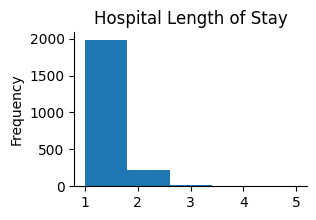

In [ ]:
print("####################### Trauma Patient Summary #######################")
print("# nunique hadm id:", TRUM_df.hadm_id.nunique())

print( f"\nFor Each Pacient(hadm):", )
trum_demog_los = trum_demog.los_hospital_hours.describe()
print(f"hospital length of stay (In Hour), IQR: %d (%d, %d))"%(trum_demog_los['50%'], trum_demog_los['25%'], trum_demog_los['75%']))
print(f"Died in Hospital: %.2f"%(trum_demog.hospital_expire_flag.sum()/trum_demog.hospital_expire_flag.shape[0]))
# print(f"# of icustay: %d(Q3), %d(max)"%(icu_count['75%'], icu_count['max']))
print(f"# of icustay:")
icu_count_df = TRUM_df.groupby('hadm_id').icustay_id.count()
display(icu_count_df.describe()[['min', '25%', '50%','75%', 'max']])

icu_count_df.plot(kind='hist', bins=5, title='Hospital Length of Stay', figsize=(3,2))
plt.gca().spines[['top', 'right',]].set_visible(False)

####################### Culture Record Summary #######################
#of nunique hadm id: 1839
#of nunique culture: 38
total #of culture record: 42558

for each pacient, # of culture record:


count    1839.000000
mean       23.141925
std        29.008985
min         1.000000
25%         5.000000
50%        14.000000
75%        30.000000
max       317.000000
Name: cx_time, dtype: float64

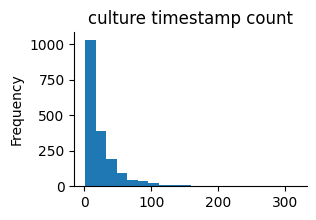

In [ ]:
print("####################### Culture Record Summary #######################")
print("#of nunique hadm id:", cx_df.hadm_id.nunique()) # not all patient have culture events
print("#of nunique culture:", cx_df.spec_type_desc.nunique())
print("total #of culture record:", cx_df.shape[0])

print( "\nfor each pacient, # of culture record:")
cx_timestamp_count = cx_df.groupby('hadm_id').cx_time.count()
display(cx_timestamp_count.describe())

from matplotlib import pyplot as plt
cx_timestamp_count.plot(kind='hist', bins=20, title='culture timestamp count', figsize=(3,2))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# list all culture item
cx_item_df = cx_df[
    ['spec_itemid', 'spec_type_desc', 'linksto']
    ].drop_duplicates().sort_values(['linksto', 'spec_itemid'])
cx_item_df.nunique()

spec_itemid       40
spec_type_desc    38
linksto            2
dtype: int64

####################### Antibiotic Record Summary #######################
#of unique hadm id: 1580
#of unique antibiotic: 43
total #of antibiotic record: 48831

for each pacient, # of antibiotic record:


count    1580.000000
mean       30.905696
std        28.803026
min         1.000000
25%        11.000000
50%        24.000000
75%        41.000000
max       328.000000
Name: abx_time, dtype: float64

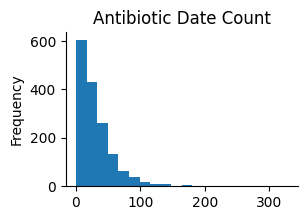

In [ ]:
print("####################### Antibiotic Record Summary #######################")
print("#of unique hadm id:", abx_df.hadm_id.nunique()) # not all patient have Antibiotic records
print("#of unique antibiotic:", abx_df.drug.nunique())
print("total #of antibiotic record:", abx_df.shape[0])

print("\nfor each pacient, # of antibiotic record:")
abx_timestamp_count = abx_df.groupby('hadm_id').abx_time.count()
display(abx_timestamp_count.describe())

from matplotlib import pyplot as plt
abx_timestamp_count.plot(kind='hist', bins=20, title='Antibiotic Date Count', figsize=(3,2))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
abx_df[['gsn', 'drug', 'drug_name_generic','route','isProphylactic']]\
      .drop_duplicates()\
      .sort_values(['gsn', 'drug']) \
      .nunique()

gsn                  77
drug                 43
drug_name_generic     9
route                 3
isProphylactic        2
dtype: int64

####################### SOFA Score Summary #######################
#of unique hadm id: 2242
total #of SOFA records: 478007

for each pacient, # of SOFA record:


count    2242.000000
mean      213.205620
std       212.458573
min         4.000000
25%        71.000000
50%       142.000000
75%       286.000000
max      3034.000000
Name: hr, dtype: float64

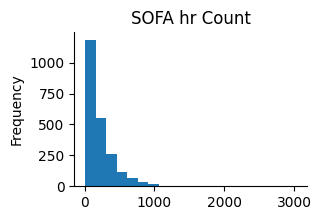

In [ ]:
print("####################### SOFA Score Summary #######################")
print("#of unique hadm id:", sofa_df.hadm_id.nunique()) # record as every hour the adult patient was in the ICU
print("total #of SOFA records:", sofa_df.shape[0])

print("\nfor each pacient, # of SOFA record:")
sofa_hr_count = sofa_df.groupby('hadm_id').hr.count()
display(sofa_hr_count.describe())

from matplotlib import pyplot as plt
sofa_hr_count.plot(kind='hist', bins=20, title='SOFA hr Count', figsize=(3,2))
plt.gca().spines[['top', 'right',]].set_visible(False)